# TreeEnsembleRegressor and parallelisation

The operator [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor) describe any tree model (decision tree, random forest, gradient boosting). The runtime is usually implements in C/C++ and uses parallelisation. The notebook studies the impact of the parallelisation.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Graph

The following graph shows the time ratio between two runtimes depending on the number of observations in a batch (N) and the number of trees in the forest.

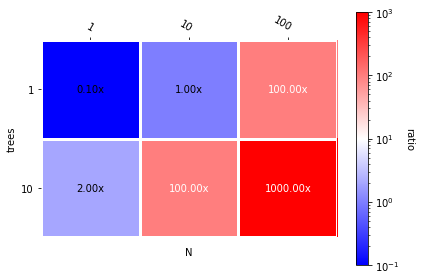

In [3]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(numpy.arange(data.shape[1]))
    ax.set_yticks(numpy.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(numpy.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(numpy.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, numpy.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_metric(metric, ax, xlabel="N", ylabel="trees"):
    x = numpy.array(list(sorted(set(k[0] for k in metric))))
    y = numpy.array(list(sorted(set(k[1] for k in metric))))        
    rx = {v: i for i, v in enumerate(x)}
    ry = {v: i for i, v in enumerate(y)}

    X, Y = numpy.meshgrid(x, y)
    zm = numpy.zeros(X.shape, dtype=numpy.float64)
    for k, v in metric.items():
        zm[ry[k[1]], rx[k[0]]] = v

    xs = [str(_) for _ in x]
    ys = [str(_) for _ in y]
    vmin = min(metric.values())
    vmax = max(metric.values())
    im, cbar = heatmap(zm, ys, xs, ax=ax, cmap="bwr", cbarlabel="ratio",
                       norm=LogNorm(vmin=vmin, vmax=vmax))
    texts = annotate_heatmap(im, valfmt="{x:.2f}x")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    
data = {(1, 1): 0.1, (10, 1): 1, (1, 10): 2, (10, 10): 100, (100, 1): 100, (100, 10): 1000}

fig, ax = plt.subplots()
plot_metric(data, ax)
fig.tight_layout();

## scikit-learn: T trees vs 1 tree

Let's do first compare a random forest from *scikit-learn* with 1 tree against multiple trees.

In [4]:
from sklearn.datasets import make_regression
ntest = 1000
X, y = make_regression(n_samples=10000 + ntest, n_features=10, n_informative=5,
                       n_targets=1, random_state=11)
X_train, X_test, y_train, y_test = X[:-ntest], X[-ntest:], y[:-ntest], y[-ntest:]

In [5]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

N = [1, 10, 100, 1000, 10000]
T = [1, 2, 10, 20, 50]

models = {}
for nt in tqdm(T):
    rf = RandomForestRegressor(n_estimators=nt, max_depth=5).fit(X_train, y_train)
    models[nt] = rf

100%|██████████| 5/5 [00:02<00:00,  1.33it/s]


In [6]:
import sklearn
from mlprodict.onnxrt.validate.validate_benchmark import benchmark_fct

def benchmark(X, fct1, fct2, N, repeat=10, number=20):
    
    def ti(r, n):
        if n <= 1:
            return 40 * r
        if n <= 10:
            return 10 * r
        if n <= 100:
            return 4 * r
        if n <= 1000:
            return r
        return r // 2
    
    with sklearn.config_context(assume_finite=True):
        # to warm up the engine
        time_kwargs = {n: dict(repeat=10, number=10) for n in N}
        benchmark_fct(fct1, X, time_kwargs=time_kwargs, skip_long_test=False)
        benchmark_fct(fct2, X, time_kwargs=time_kwargs, skip_long_test=False)
        # real measure
        time_kwargs = {n: dict(repeat=ti(repeat, n), number=number) for n in N}
        res1 = benchmark_fct(fct1, X, time_kwargs=time_kwargs, skip_long_test=False)
        res2 = benchmark_fct(fct2, X, time_kwargs=time_kwargs, skip_long_test=False)
    res = {}
    for r in sorted(res1):
        r1 = res1[r]
        r2 = res2[r]
        ratio = r2['total'] / r1['total']
        res[r] = ratio
    return res


def tree_benchmark(X, fct1, fct2, T, N, repeat=20, number=10):
    bench = {}
    for t in tqdm(T):
        r = benchmark(X, fct1(t), fct2(t), N, repeat=repeat, number=number)
        for n, v in r.items():
            bench[n, t] = v
    return bench

bench = tree_benchmark(X_test.astype(numpy.float32),
                       lambda t: models[1].predict,
                       lambda t: models[t].predict, T, N)

list(bench.items())[:3]

100%|██████████| 5/5 [01:20<00:00, 19.35s/it]


[((1, 1), 0.9760457855545297),
 ((10, 1), 0.9147578680294024),
 ((100, 1), 0.7756775134240294)]

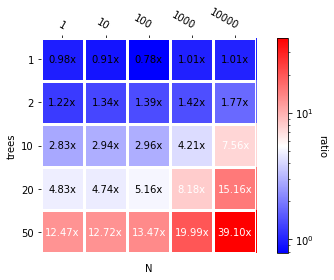

In [7]:
fig, ax = plt.subplots()
plot_metric(bench, ax)
fig.tight_layout();

As expected, all ratio on first line are close to 1 since both models are the same. fourth line, second column (T=20, N=10) means a random forest with 20 trees is around 5 times slower to compute the predictions of 10 observations in a batch compare to a random forest with 1 tree.

## scikit-learn against onnxuntime

In [8]:
from skl2onnx import to_onnx
X32 = X_test.astype(numpy.float32)
models_onnx = {t: to_onnx(m, X32[:1]) for t, m in models.items()}

In [9]:
from onnxruntime import InferenceSession
sess_models = {t: InferenceSession(mo.SerializeToString()) for t, mo in models_onnx.items()}

In [10]:
bench_ort = tree_benchmark(X_test.astype(numpy.float32),
                           lambda t: models[t].predict,
                           lambda t: (lambda x, t_=t, se=sess_models: se[t_].run(None, {'X': x})),
                           T, N)

100%|██████████| 5/5 [01:27<00:00, 21.10s/it]


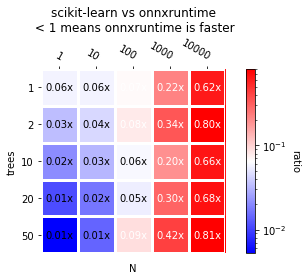

In [11]:
fig, ax = plt.subplots()
plot_metric(bench_ort, ax)
ax.set_title("scikit-learn vs onnxruntime\n < 1 means onnxruntime is faster")
fig.tight_layout();

In [12]:
from onnxruntime import __version__ as ort_version
ort_version

'1.1.997'

We clearly see this version of onnxruntime is fast for small batches, still faster but not that much for big batches.

## Implementation details for mlrodict runtime

The runtime implemented in [mlprodict]() mostly relies on two files:
* [op_tree_ensemble_common_p_agg_.hpp](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_tree_ensemble_common_p_agg_.hpp)
* [op_tree_ensemble_common_p_.hpp](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_tree_ensemble_common_p_.hpp)

The runtime builds a tree structure, computes the output of every tree and then agregates them. The implementation distringuishes when the batch size contains only 1 observations or many. It parallelizes on the following conditions:
* if the batch size $N \geqslant N_0$, it then parallizes per observation, asuming every one is independant,
* if the batch size $N = 1$ and the number of trees $T \geqslant T_0$, it then parallizes per tree.

## scikit-learn against mlprodict, no parallelisation

In [13]:
from mlprodict.onnxrt import OnnxInference
oinf_models = {t: OnnxInference(mo, runtime="python_compiled") for t, mo in models_onnx.items()}

Let's disable the parallelisation.

In [14]:
for _, oinf in oinf_models.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 10000000
    oinf.sequence_[0].ops_.rt_.omp_N_ = 10000000

In [15]:
bench_mlp = tree_benchmark(X_test.astype(numpy.float32),
                           lambda t: models[t].predict,
                           lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
                           T, N)

100%|██████████| 5/5 [01:14<00:00, 18.38s/it]


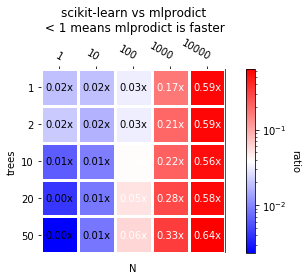

In [16]:
fig, ax = plt.subplots()
plot_metric(bench_mlp, ax)
ax.set_title("scikit-learn vs mlprodict\n < 1 means mlprodict is faster")
fig.tight_layout();

In [17]:
from mlprodict import __version__ as mlp_version
mlp_version

'0.3'

This implementation seems to be faster. And with parallelisation.

In [18]:
for _, oinf in oinf_models.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 2
    oinf.sequence_[0].ops_.rt_.omp_N_ = 2

In [19]:
bench_mlp_para = tree_benchmark(X_test.astype(numpy.float32),
                                lambda t: models[t].predict,
                                lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
                                T, N)

100%|██████████| 5/5 [01:09<00:00, 17.04s/it]


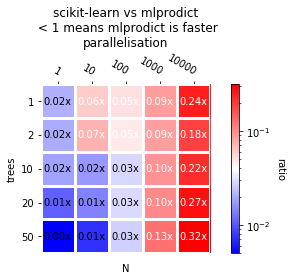

In [20]:
fig, ax = plt.subplots()
plot_metric(bench_mlp_para, ax)
ax.set_title("scikit-learn vs mlprodict\n < 1 means mlprodict is faster\nparallelisation")
fig.tight_layout();

Parallelisation does improve the computation time when N is big. Let's compare with and without parallisation.

In [21]:
bench_para = {}
for k, v in bench_mlp.items():
    bench_para[k] = bench_mlp_para[k] / v

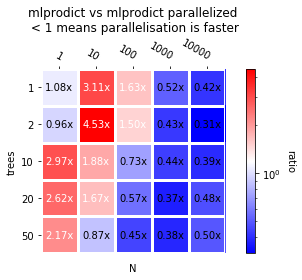

In [22]:
fig, ax = plt.subplots()
plot_metric(bench_para, ax)
ax.set_title("mlprodict vs mlprodict parallelized\n < 1 means parallelisation is faster")
fig.tight_layout();

Parallisation per trees does not seem to be efficient. Let's confirm with a proper benchmark.

In [23]:
for _, oinf in oinf_models.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 1000000
    oinf.sequence_[0].ops_.rt_.omp_N_ = 1000000

oinf_models_para = {t: OnnxInference(mo, runtime="python_compiled") for t, mo in models_onnx.items()}
for _, oinf in oinf_models_para.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 2
    oinf.sequence_[0].ops_.rt_.omp_N_ = 2

bench_mlp_para = tree_benchmark(X_test.astype(numpy.float32),
                                lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
                                lambda t: (lambda x, t_=t, oi=oinf_models_para: oi[t_].run({'X': x})),
                                T, N)

100%|██████████| 5/5 [00:10<00:00,  2.56s/it]


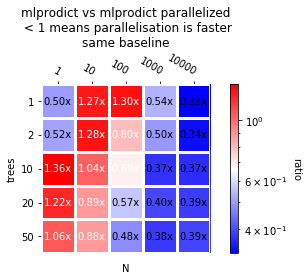

In [24]:
fig, ax = plt.subplots()
plot_metric(bench_mlp_para, ax)
ax.set_title("mlprodict vs mlprodict parallelized\n < 1 means parallelisation is faster\nsame baseline")
fig.tight_layout();

It should be run on different machines. On the current one, parallelisation per trees (when N=1) does not seem to help. Parallisation for a small number of observations does not seem to help either. So we need to find some threshold.